In [1]:
from sklearn import svm
from skimage import color
from skimage import io
from scipy import ndimage
from scipy.cluster.vq import *
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.cluster import MeanShift, estimate_bandwidth
from imutils import paths
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob,itertools,time,zipfile,pickle,time,os,warnings,copy

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
cd Final-Assignment

/Users/onur_yilmaz/Desktop/CV_HW3/Final-Assignment


In [3]:
class_names = [name[8:30] for name in glob.glob('./train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("Class_names: %s " % class_names)
n_train_samples_per_class = 40
n_test_samples_per_class = 100

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % class_name)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.resize((cv2.imread(filename, 0)), (150,150)))
    return data, labels

# load training dataset
print('\n       Loading Training Dataset')
train_data, train_label = load_dataset('./train/', n_train_samples_per_class)
n_train = len(train_label)

print('\n       Loading Testing Dataset')
test_data, test_label = load_dataset('./validation/', n_test_samples_per_class)
n_test = len(test_label)

Class_names: {0: 'airplanes', 1: 'cars', 2: 'motorbikes', 3: 'faces'} 

       Loading Training Dataset
Loading images from class: airplanes
Loading images from class: cars
Loading images from class: motorbikes
Loading images from class: faces

       Loading Testing Dataset
Loading images from class: airplanes
Loading images from class: cars
Loading images from class: motorbikes
Loading images from class: faces


In [4]:
def resize(data, dim):
    res = copy.deepcopy(data)
    for i in range(0, len(data)):
        res[i] = cv2.resize(data[i], (dim, dim))        
    return res

resize_train = resize(train_data, 32)
resize_test = resize(test_data, 32)

def stretch(data, dim):
    x = np.zeros((len(data), dim*dim))
    for i in range(0, len(data)):
        x[i,:] = np.reshape(data[i], (1,dim*dim))
    return x

train_x = stretch(resize_train, 32)
test_x = stretch(resize_test, 32)

In [5]:
# feature extraction
def extract_features(raw_data):
    #I used 256 features - which obtained from resized 16*16 image
    featu_dim = 1024
    featu_data = np.zeros((len(raw_data), featu_dim), dtype=np.float32)
    num_rows = featu_data.shape[0]
    for i in np.arange(num_rows):
        #Normalize
        norm_image = cv2.normalize(raw_data[i], None, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
        featu_data[i] = np.reshape(norm_image, (norm_image.size))[:featu_dim]
    return featu_data

In [6]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
t11 = time.time()
#features of train and test data
train_feat = extract_features(train_x)
test_feat = extract_features(test_x)

#Using nearest centroid
clf = NearestCentroid()
clf.fit(train_feat, train_label)

label1 = test_label
#predictions
pred2 = clf.predict(test_feat)

t12 = time.time()
#accuracy
time3 = t12-t11
accuracy1 = sum(np.array(pred2) == label1)*100 / float(n_test)
print("Accuracy(T) =", accuracy1)
print("Time Taken = ", time3)



Accuracy(T) = 70.5
Time Taken =  0.03189706802368164


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
bandwidth = estimate_bandwidth(train_x, n_jobs=-1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(train_x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

#Predicting k number by mean sift
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("Number of estimated clusters : %d" % n_clusters_)

Number of estimated clusters : 1


In [8]:
def clustering(image_list):
    k_value = 50
    desc_list = []
    for img in image_list:
        extractor = cv2.xfeatures2d.SIFT_create()
        kp, des = extractor.detectAndCompute(img, None)
        
        dkp = [cv2.KeyPoint(k.pt[0], k.pt[1],k.size) for k in kp]
        keyp, descriptors = extractor.compute(img, kp)
        desc_list.append(descriptors)
        
    desc_list=np.asarray(desc_list)
    desc_list=np.concatenate(desc_list, axis=0)
    kmeans = KMeans(n_clusters=k_value, random_state=0).fit(desc_list)
    img=cv2.drawKeypoints(img,kp, img)
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()
    return kmeans

In [9]:
def histogram(image_list,kmeans):
    features = []
    for img in image_list:
        extractor = cv2.xfeatures2d.SIFT_create()
        kp = extractor.detect(img)        
        dkp = [cv2.KeyPoint(k.pt[0], k.pt[1],k.size) for k in kp]
        keyp, descriptors = extractor.compute(img, dkp)
        keyp, descriptors = extractor.compute(img, dkp)
        predict_class = kmeans.predict(descriptors)
        hist, bin_edges=np.histogram(predict_class)
        features.append(hist)
    
    features=np.asarray(features)
    return features

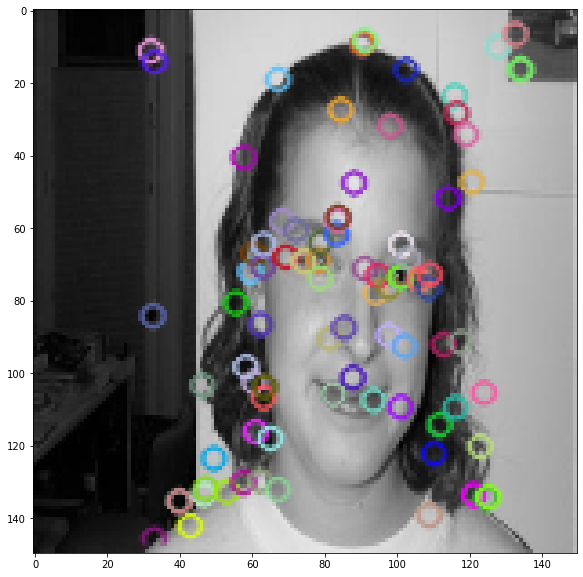

Time Consumption for Clustering Features:  69.495633 seconds


In [10]:
start = time.process_time()
kmeans = clustering(train_data)
time7 = time.process_time() - start
print("Time Consumption for Clustering Features: ",time7 , "seconds")

In [11]:
start = time.process_time()
train_feat = histogram(train_data,kmeans)
test_feat = histogram(test_data,kmeans)
time8 = time.process_time() - start
print("Time Consumption for Histogram Generation: ",time8 , "seconds")

Time Consumption for Histogram Generation:  38.06245399999999 seconds


In [12]:
dataset_path = './train/'
categories = os.listdir(dataset_path)
image_paths = []
image_classes = []
class_id = 0
for category in categories:
    dir = os.path.join(dataset_path, category)
    class_path = list(paths.list_images(dir))
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path) 
    class_id+=1
sift = cv2.xfeatures2d.SIFT_create()
des_list = []
for image_path in image_paths:
    im  = cv2.imread(image_path)
    im  = cv2.resize(im,(150,150))
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)
    des_list.append((image_path, kp, des))

In [13]:
#Stacking all the descriptors in a numpy array 
descriptors = des_list[0][2]
for image_path, keypoints, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))
print("Done!")

#pickle.dump(descriptors, open('descriptors1.sav', 'wb'))

Done!


In [14]:
from scipy.cluster.vq import *
# Perform k-means dictionary clustering
k = 50
voc, variance = kmeans(descriptors, k, 1)

im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    print("Calculating distance for image "+str(i+1)+"...", end="\r")
    words, distance = vq(des_list[i][2],voc)
    for w in words:
        im_features[i][w] += 1
print('\nDone!')    

Calculating distance for image 160...
Done!


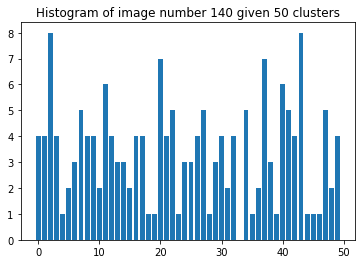

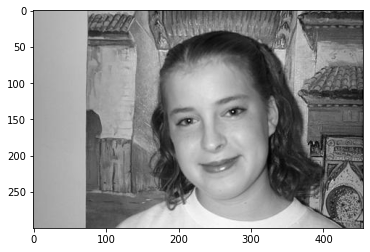

In [15]:
IMAGE_N = 140
plt.bar(range(k), im_features[IMAGE_N])
plt.title("Histogram of image number "+ str(IMAGE_N) +" given "+ str(k) + " clusters")
plt.show()

im = cv2.imread(des_list[IMAGE_N][0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray')

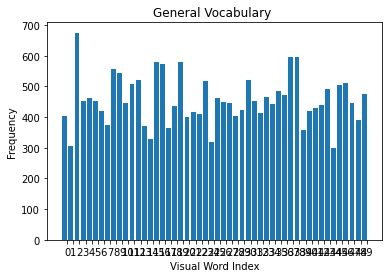

In [16]:
number_of_cluster = k
x_scalar = np.arange(number_of_cluster)
y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(number_of_cluster)])
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.title("General Vocabulary ")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

In [17]:
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Standardizing the histogram matrix
train_featn = scaler.fit_transform(train_feat)
test_featn = scaler.fit_transform(test_feat)

label3 = test_label.copy()

start = time.process_time()
clf = svm.LinearSVC(random_state=0, C = 4.6)    #Using lambda = 4.6 
clf.fit(train_featn, train_label) 
time5 = time.process_time() - start
print("Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) : ",time5 , "seconds")

start = time.process_time()
pred3 = clf.predict(test_featn)
time6 = time.process_time() - start
print("Using Lambda = 4.6")
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(label3,pred3)*100)) 
print("Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) : ",time6 , "seconds")

Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) :  0.02883299999999167 seconds
Using Lambda = 4.6
The Prediction accuracy of this model is 67.25%
Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) :  0.0015059999999920137 seconds


In [18]:
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Standardizing the histogram matrix
train_featn = scaler.fit_transform(train_feat)
test_featn = scaler.fit_transform(test_feat)

label3 = test_label.copy()

start = time.process_time()
clf = svm.LinearSVC(random_state=0, C = 4.6)    #Using lambda = 4.6 
clf.fit(train_featn, train_label) 
time5 = time.process_time() - start
print("Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) : ",time5 , "seconds")

start = time.process_time()
pred3 = clf.predict(test_featn)
time6 = time.process_time() - start
print("Using Lambda = 4.6")
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(label3,pred3)*100)) 
print("Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) : ",time6 , "seconds")

Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) :  0.028923000000006027 seconds
Using Lambda = 4.6
The Prediction accuracy of this model is 67.25%
Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) :  0.001331999999990785 seconds


KeyPoint + Nearest Neighbor Classifier with K=50: 

The Prediction accuracy of this model is 70.50%


<Figure size 1152x1152 with 0 Axes>

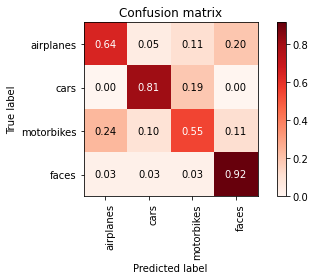

Confusion Matrix Description(Bag of SIFT Representation + Nearest Neighbor Classifier): 

The Prediction accuracy of this model is 67.25%
Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) :  0.001331999999990785 seconds


<Figure size 1152x1152 with 0 Axes>

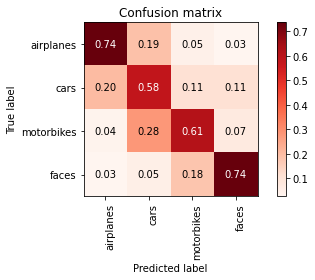

In [19]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Reds):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax

c_names = [name[8:] for name in glob.glob('./train/*')]

# Confusion matrix
print("KeyPoint + Nearest Neighbor Classifier with K=50: \n")
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(test_label,pred2)*100)) 
#print("Time Consumption in Prediction (Bag of SIFT Representation + Nearest Neighbor Classifer) : ",time4 , "seconds")
cm2 = confusion_matrix(pred2, test_label)
plt.figure(figsize=(16,16))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()
print("Confusion Matrix Description(Bag of SIFT Representation + Nearest Neighbor Classifier): \n")

# Confusion matrix
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(label3,pred3)*100)) 
print("Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) : ",time6 , "seconds")
cm3 = confusion_matrix(pred3, label3)
plt.figure(figsize=(16,16))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()
